# Asymmetry test series

For the paper, for each measurement, generate plots of how the asymmetry measurement depends on 
1) Signal-to-noise
2) Pixel scale
3) PSF FWHM

Keeping all other parameters constant. For constant values, choose:

* Pixel scale: 0.1" (about 180pc at z=0.1, 300pc at z=0.2)
* PSF FWHM: 0.8" (good ground-based seeing)
* Noise level: 25 mag/arcsec$^2$ (pretty deep imaging)


#### Imports

In [1]:
%reload_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from galaxy_generator import get_galaxy_rng_vals, get_augmentation_rng_vals, simulate_perfect_galaxy, add_source_to_image, sky_noise
from asymmetry import get_asymmetry, fourier_deconvolve
from astropy.convolution import Gaussian2DKernel
from astropy.stats import sigma_clipped_stats, gaussian_fwhm_to_sigma
from photutils import aperture

seed = 48
perfect_pxscale = 0.1
std_mag = 30
std_psf_fwhm = 0.3
std_pxscale = 0.1
ap_frac = 1.5

convolve_nyquist = True

In [2]:
plt.rcParams['font.size'] = 10
plt.rcParams['xtick.minor.size'] = 1

## Generating a galaxy

We use a single galaxy for all the plots here, generated with the same set of parameters. 

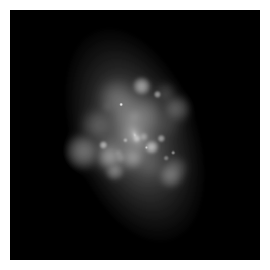

In [3]:
params = get_galaxy_rng_vals(1, seed=seed)[0]
img_perfect, galaxy_dict, r_pet = simulate_perfect_galaxy(pxscale=perfect_pxscale,  **params)
img_perfect = add_source_to_image(**galaxy_dict, psf_fwhm=3*perfect_pxscale, pxscale=perfect_pxscale, psf_method='astropy')

plt.imshow(-2.5*np.log10(img_perfect/perfect_pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
plt.axis('off');

In [4]:
### def augment(pxscale, psf_fwhm, sky_mag):
    
#     img_lowres, out_dict, r_pet = simulate_perfect_galaxy(pxscale=pxscale, **params)
#     img_psf = add_source_to_image(**out_dict, psf_fwhm=psf_fwhm, pxscale=pxscale, psf_method='astropy')
#     img_noisy, sky_flux = sky_noise(img_psf, sky_mag=sky_mag, pixel_scale=pxscale, rms_noise=True)
#     return img_noisy, img_lowres

In [5]:
# plt.imshow(-2.5*np.log10(img_noisy/perfect_pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')

#### Aside: deconvolution
Test deconvolution:

In [6]:
# from numpy import fft
# from asymmetry import _fit_snr

# def fourier_deconvolve2(img, psf, noise, pxscale, convolve_nyquist=False):

#     # img = np.pad(img, (20,20))
#     # psf = np.pad(psf, (20,20))

#     # Transform the image and the PSF
#     img_fft = fft.fft2(img)
#     psf_fft = fft.fft2(fft.ifftshift(psf))
    
#     noise_fft = np.median(np.abs(img_fft))
#     # noise_fft = noise * img_fft.shape[0] 

#     # Get the SNR
#     snr = fit_snr2(img_fft, noise_fft)

#     # If True, convolve down to Nyquist frequency
#     if convolve_nyquist:
#         nyquist_psf = Gaussian2DKernel(2, x_size=img.shape[1], y_size=img.shape[0])
#         nyquist_fft = fft.fft2(fft.ifftshift(nyquist_psf))
#     else:
#         nyquist_fft = 1
        
#     # Deconvolve
#     H_sq = np.power((1 + 1/snr), 2) / np.power((np.abs(psf_fft) + 1/snr), 2)
#     H = np.sqrt(H_sq)
    
#     # H = (nyquist_fft + 1/snr) / (psf_fft + 1/snr)
#     img_corr = img_fft * H

#     # Do an inverse transform
#     img_deconv = np.real(fft.ifft2(img_corr))

#     # img_deconv = img_deconv[20:-20, 20:-20]
#     return img_deconv

In [7]:
# from scipy.interpolate import griddata
# def fit_snr2(img_fft, noise_fft, snr_thresh=3, quant_thresh=0.98):
#     """Given an FFT of an image and a noise level, estimate SNR(omega)
#     by interpolating high SNR regions and setting high-frequency SNR to 1k less than SNR max.
#     """
    

#     # Calculate from the image SNR
#     snr = np.abs(img_fft) / noise_fft
#     snr_min = np.log10(np.max(snr)) - 4  # Minimum SNR is 100000 times dimmer than the center
    
#     # Only look at one quarter of the array (FFT is reflected along x and y)
#     xc = int(img_fft.shape[0]/2)
#     snr_corner = snr[:xc, :xc]
    
#     # Image x, y arrays as placeholders
#     xs = np.arange(xc+1)
#     XS, YS = np.meshgrid(xs, xs)
    
#     # Choose indices where SNR is high 
#     snr_lim = np.quantile(snr_corner, quant_thresh)
#     snr_lim = np.max([snr_lim, snr_thresh])
#     good_ids = np.nonzero(snr_corner > snr_lim)
#     good_log_snr = np.log10(snr_corner[good_ids])
    
#     # Select regions dominated by noise and set their SNR to snr_min
#     noise_ids = np.nonzero(snr_corner < 1)   
#     noise_log_snr = snr_min*np.ones(len(noise_ids[0]))

#     # SNR array to interpolate
#     log_snr = np.concatenate((good_log_snr, noise_log_snr))
#     snr_ids = np.hstack((good_ids, noise_ids))
#     snr_ids = (snr_ids[0], snr_ids[1])
#     xs = XS[snr_ids]
#     ys = YS[snr_ids]

#     # Add a low SNR at highest frequency edges to help interpolation
#     boundaries = np.arange(xc+1)
#     xs = np.concatenate((xs, np.ones_like(boundaries)*(xc+1), boundaries))
#     ys = np.concatenate((ys, boundaries, np.ones_like(boundaries)*(xc+1)))
#     log_snr = np.concatenate((log_snr, snr_min*np.ones_like(boundaries), snr_min*np.ones_like(boundaries)))

#     # Interpolate
#     snr_grid = griddata((xs, ys), log_snr, (XS, YS), method='linear')
    

#     # Expand the grid (corner) back to the original shape by doubling in X and Y
#     j = -1 
#     k = -1 if (snr.shape[0] % 2 == 1) else -2
#     fit_snr = np.ones_like(snr)
#     fit_snr[:xc,:xc] = snr_grid[:j, :j]
#     fit_snr[xc:,:xc] = snr_grid[k::-1, :j]
#     fit_snr[:xc,xc:] = snr_grid[:j, k::-1]
#     fit_snr[xc:,xc:] = snr_grid[k::-1, k::-1]
    
#     # Undo the log
#     fit_snr = np.power(10, fit_snr)

#     # Rewrite the good SNR regions with real values
#     good_ids = np.nonzero(snr > snr_lim)
#     fit_snr[good_ids] = snr[good_ids]
    
#     return fit_snr

In [8]:
# pxscale = 0.2
# psf_fwhm = 3
# psf_std = psf_fwhm * gaussian_fwhm_to_sigma 
# sky_mag = 30

# img_noisy, img_lowres = augment(pxscale, psf_fwhm, sky_mag)
# # psf_nyquiest = Gaussian2DKernel(
# psf = Gaussian2DKernel(psf_std/pxscale, x_size=img_noisy.shape[1], y_size=img_noisy.shape[0]).array
# _, bgsd, _ = sigma_clipped_stats(img_noisy)
# bgsd = 1.6

# img_deconv = fourier_deconvolve2(img_noisy, psf, bgsd, 0.3, False)

In [9]:
# fig, axs = plt.subplots(1,3,figsize=(7.53, 2.5))

# axs[0].imshow(((img_deconv)/pxscale**2), vmin=0, vmax=5e5, cmap='gray')
# axs[1].imshow(((img_noisy)/pxscale**2), vmin=0, vmax=5e5, cmap='gray')
# axs[2].imshow(((img_lowres)/pxscale**2) , vmin=0, vmax=5e5, cmap='gray')

# for ax in axs:
#     ax.axis('off')
    
# plt.subplots_adjust(wspace=0.01)

In [10]:
# fig, axs = plt.subplots(1,3,figsize=(7.53, 2.5))

# axs[0].imshow(-2.5*np.log10(np.abs(img_deconv)/pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
# axs[1].imshow(-2.5*np.log10(np.abs(img_noisy)/pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
# axs[2].imshow(-2.5*np.log10(np.abs(img_lowres)/pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')

# for ax in axs:
#     ax.axis('off')
    
# plt.subplots_adjust(wspace=0.01)

## Calculating asymmetry

Calculate 4 different asymmetry measurements:

* CAS |A|
* Corrected CAS |A|
* $A^2$
* Fourier $A^2$

For a given galaxy

In [11]:
def get_asymmetry_measurements(img_obs, pxscale, ap_frac=1.5):
    
    #### Calculate noisy asymmetries
    a_cas, _ = get_asymmetry(img_obs, ap_frac*r_pet/pxscale, a_type='cas', sky_type='annulus', bg_corr='residual', sky_annulus=[2, 3])
    a_cas_corr, _ = get_asymmetry(img_obs, ap_frac*r_pet/pxscale, a_type='cas_corr', sky_type='annulus', bg_corr='residual', sky_annulus=[2, 3])
    a_sq, _ = get_asymmetry(img_obs, ap_frac*r_pet/pxscale, a_type='squared', sky_type='annulus', bg_corr='full', sky_annulus=[2, 3])
    
    ##### Store output
    output = {
        'a_cas' : a_cas, 'a_cas_cor' : a_cas_corr, 
        'a_sq' : a_sq,
    }
    
    return output
    

### Real asymmetry

In [12]:
a_cas_real, _ = get_asymmetry(img_perfect, ap_frac*r_pet/perfect_pxscale, a_type='cas', sky_type='annulus', bg_corr='residual', sky_annulus=[2, 3])
a_sq_real, xc = get_asymmetry(img_perfect, ap_frac*r_pet/perfect_pxscale, a_type='squared', sky_type='annulus', bg_corr='full', sky_annulus=[2, 3])

print(a_cas_real, a_sq_real)

0.7460147718482902 0.9179554178760501


## Noise dependence

We use the same set-up as for all other tests, but for these test series, only test on a single galaxy. Make a realization with one seed so we know it's always the same if the kernel is refreshed

* Generate a galaxy with the perfect pixel scale, no PSF
* Generate 5 noise iterations each time


In [ ]:
sky_mags = np.linspace(20, 28, 15)
n_sims = 10

dicts = []
imgs_snr = []

for mag in tqdm(sky_mags):
    for n in range(n_sims):
        
        img_noisy, sky_flux = sky_noise(img_perfect, sky_mag=mag, pxscale=perfect_pxscale, rms_noise=True)
        out = get_asymmetry_measurements(img_noisy, perfect_pxscale)
        
        # Get SNR/pixel
        noise_arr = np.sqrt( (img_perfect) + sky_flux**2 )
        ap = aperture.CircularAperture(xc, ap_frac*r_pet/perfect_pxscale)
        snr = ap.do_photometry(img_noisy)[0][0]/ap.do_photometry(noise_arr)[0][0] 
        
        out['mag'] = mag
        out['n'] = n
        out['snr'] = snr
        imgs_snr.append(img_noisy)
        
        dicts.append(out)
sky_mags_df = pd.DataFrame(dicts)

  0%|          | 0/15 [00:00<?, ?it/s]

### CAS asymmetry 

In [ ]:
plt.rcParams['font.size'] = 10
plt.rcParams['xtick.minor.size'] = 1.5
plt.rcParams['ytick.minor.size'] = 1.5

Text(0.5, 0, '$\\langle$SNR$\\rangle$')

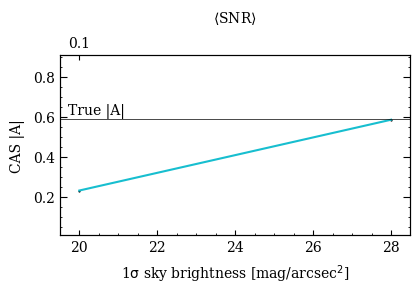

In [60]:
plt.figure(figsize=(3.5,1.8))
ax = plt.axes()
ax_snr = ax.twiny()

# Data points
ax.scatter(sky_mags_df.mag, sky_mags_df.a_cas, color='k', s=10)

# Median
qs = sky_mags_df.groupby(by='mag').quantile(q=[0.16, 0.5, 0.84])
ax.plot(sky_mags, qs.xs(0.5, level=1).a_cas, color='C9')
ax.fill_between(sky_mags, qs.xs(0.16, level=1).a_cas, qs.xs(0.84, level=1).a_cas, color='C9', alpha=0.2)
ax.axhline(a_cas_real, color='k', lw=0.5)

# Annotations
ax.annotate('True |A|', xy=(19.7, a_cas_real+0.005), size=10, ha='left', va='bottom')

# SNR ticks
ax_snr.set_xticks(sky_mags[::2])
ax_snr.set_xticklabels([f'{x:0.1f}' for x in sky_mags_df.snr[::2]])

# Limits
ax.set_xlim(19.51, 28.49)
ax_snr.set_xlim(19.51, 28.49)
ax.set_ylim(0.01, 0.91)
ax.set_ylabel('CAS |A|')
ax.set_xlabel(r'1$\sigma$ sky brightness [mag/arcsec$^2$]')
ax_snr.set_xlabel(r'$\langle$SNR$\rangle$', labelpad=10)

# plt.savefig('figures/paper/cas_a_snr.pdf', bbox_inches='tight')

### Corrected CAS

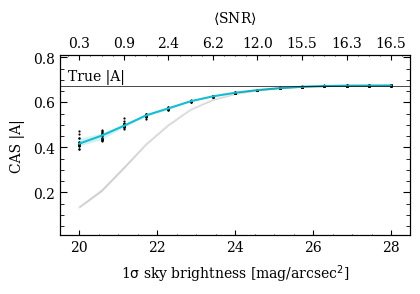

In [149]:
plt.figure(figsize=(3.5,1.8))
ax = plt.axes()
ax_snr = ax.twiny()

# Data points
ax.scatter(sky_mags_df.mag, sky_mags_df.a_cas_cor, color='k', s=10)

# Median
qs = sky_mags_df.groupby(by='mag').quantile(q=[0.16, 0.5, 0.84])
ax.plot(sky_mags, qs.xs(0.5, level=1).a_cas_cor, color='C9')
ax.fill_between(sky_mags, qs.xs(0.16, level=1).a_cas_cor, qs.xs(0.84, level=1).a_cas_cor, color='C9', alpha=0.2)
ax.axhline(a_cas_real, color='k', lw=0.5)

ax.plot(sky_mags, qs.xs(0.5, level=1).a_cas, color='k', alpha=0.1)
ax.fill_between(sky_mags, qs.xs(0.16, level=1).a_cas, qs.xs(0.84, level=1).a_cas, color='k', alpha=0.1)

# Annotations
ax.annotate('True |A|', xy=(19.7, a_cas_real+0.005), size=10, ha='left', va='bottom')

# SNR ticks
ax_snr.set_xticks(sky_mags[::2])
ax_snr.set_xticklabels([f'{x:0.1f}' for x in sky_mags_df.snr[::40]])

# Limits
ax.set_xlim(19.51, 28.49)
ax_snr.set_xlim(19.51, 28.49)
ax.set_ylim(0.01, 0.81)
ax.set_ylabel('CAS |A|')
ax.set_xlabel(r'1$\sigma$ sky brightness [mag/arcsec$^2$]')
ax_snr.set_xlabel(r'$\langle$SNR$\rangle$', labelpad=10)

plt.savefig('figures/paper/cas_a_corr_snr.pdf', bbox_inches='tight')

### Squared

In [100]:
sky_mags_df['a_sq_root'] = np.sqrt(sky_mags_df.a_sq/10)

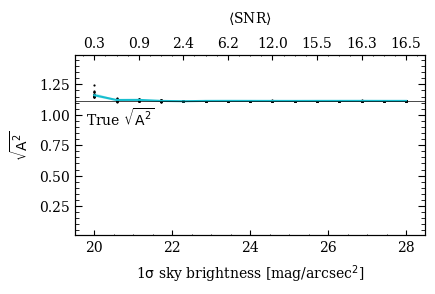

In [107]:
plt.figure(figsize=(3.5,1.8))
ax = plt.axes()
ax_snr = ax.twiny()

# Data points
ax.scatter(sky_mags_df.mag, sky_mags_df.a_sq_root, color='k', s=10)

# Median
qs = sky_mags_df.groupby(by='mag').quantile(q=[0.16, 0.5, 0.84])
ax.plot(sky_mags, qs.xs(0.5, level=1).a_sq_root, color='C9')
ax.fill_between(sky_mags, qs.xs(0.16, level=1).a_sq_root, qs.xs(0.84, level=1).a_sq_root, color='C9', alpha=0.2)
ax.axhline(np.sqrt(a_sq_real/10), color='k', lw=0.5)

# Annotations
ax.annotate(r'True $\sqrt{A^2}$', xy=(19.8, np.sqrt(a_sq_real/10)-0.05), size=10, ha='left', va='top')

# SNR ticks
ax_snr.set_xticks(sky_mags[::2])
ax_snr.set_xticklabels([f'{x:0.1f}' for x in sky_mags_df.snr[::40]])

# Limits
ax.set_xlim(19.51, 28.49)
ax_snr.set_xlim(19.51, 28.49)
ax.set_ylim(0.01, 1.49)
ax.set_ylabel(r'$\sqrt{A^2}$')
ax.set_xlabel(r'1$\sigma$ sky brightness [mag/arcsec$^2$]')
ax_snr.set_xlabel(r'$\langle$SNR$\rangle$', labelpad=10)

plt.savefig('figures/paper/sq_a_snr.pdf', bbox_inches='tight')

## PSF dependence

* Same pixel scale as for the perfect image
* Standard amount of noise (deep image, 28 mag/arcsec$^2$)
* PSF FWHM varying from 0.3 to 2 arcsec

In [14]:
psf_fwhms = np.linspace(0.2, 2, 15)
n_sims = 1

dicts = []
imgs_psf = []
for fwhm in tqdm(psf_fwhms):
    for n in range(n_sims):
        img_psf = add_source_to_image(**galaxy_dict, psf_fwhm=fwhm, pxscale=perfect_pxscale, psf_method='astropy')
        img_noisy, sky_flux = sky_noise(img_psf, sky_mag=std_mag, pixel_scale=perfect_pxscale, rms_noise=True)
        out = get_asymmetry_measurements(img_noisy, perfect_pxscale)

        out['fwhm'] = fwhm
        out['n'] = n
        
        imgs_psf.append(img_noisy)
        dicts.append(out)
        
psf_df = pd.DataFrame(dicts)

  0%|          | 0/15 [00:00<?, ?it/s]

#### CAS asymmetry

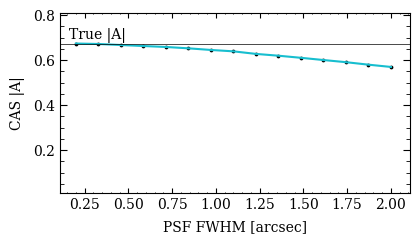

In [70]:
plt.figure(figsize=(3.5,1.8))
ax = plt.axes()

# Data points
ax.scatter(psf_df.fwhm, psf_df.a_cas, color='k', s=30)
ax.plot(psf_fwhms, psf_df.a_cas, color='C9')

# Annotations
ax.annotate('True |A|', xy=(0.16, a_cas_real+0.005), size=10, ha='left', va='bottom')
ax.axhline(a_cas_real, color='k', lw=0.5)


# Limits
ax.set_xlim(0.11, 2.11)
ax_snr.set_xlim(19.51, 28.49)
ax.set_ylim(0.01, 0.81)
ax.set_ylabel('CAS |A|')
ax.set_xlabel(r'PSF FWHM [arcsec]')
# ax_snr.set_xlabel(r'$\langle$SNR$\rangle$', labelpad=10)

plt.savefig('figures/paper/cas_a_psf.pdf', bbox_inches='tight')

#### Corrected CAS

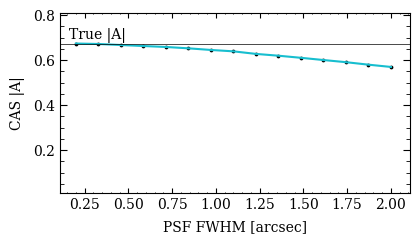

In [114]:
plt.figure(figsize=(3.5,1.8))
ax = plt.axes()

# Data points
ax.scatter(psf_df.fwhm, psf_df.a_cas_cor, color='k', s=30)
ax.plot(psf_fwhms, psf_df.a_cas_cor, color='C9')

# Annotations
ax.annotate('True |A|', xy=(0.16, a_cas_real+0.005), size=10, ha='left', va='bottom')
ax.axhline(a_cas_real, color='k', lw=0.5)


# Limits
ax.set_xlim(0.11, 2.11)
ax_snr.set_xlim(19.51, 28.49)
ax.set_ylim(0.01, 0.81)
ax.set_ylabel('CAS |A|')
ax.set_xlabel(r'PSF FWHM [arcsec]')
# ax_snr.set_xlabel(r'$\langle$SNR$\rangle$', labelpad=10)

plt.savefig('figures/paper/cas_a_corr_psf.pdf', bbox_inches='tight')

### Squared 

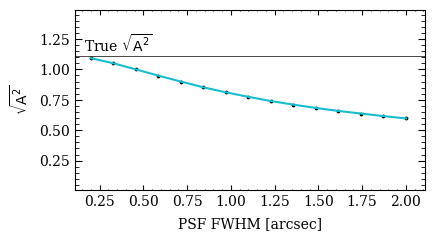

In [115]:
psf_df['a_sq_root'] = np.sqrt(psf_df.a_sq/10)

plt.figure(figsize=(3.5,1.8))
ax = plt.axes()

# Data points
ax.scatter(psf_df.fwhm, psf_df.a_sq_root, color='k', s=30)
ax.plot(psf_fwhms, psf_df.a_sq_root, color='C9')

# Annotations
ax.annotate(r'True $\sqrt{A^2}$', xy=(0.16, np.sqrt(a_sq_real/10)+0.005), size=10, ha='left', va='bottom')
ax.axhline(np.sqrt(a_sq_real/10), color='k', lw=0.5)


# Limits
ax.set_xlim(0.11, 2.11)
ax_snr.set_xlim(19.51, 28.49)
ax.set_ylim(0.01, 1.49)
ax.set_ylabel(r'$\sqrt{A^2}$')
ax.set_xlabel(r'PSF FWHM [arcsec]')
# ax_snr.set_xlabel(r'$\langle$SNR$\rangle$', labelpad=10)

plt.savefig('figures/paper/a_sq_psf.pdf', bbox_inches='tight')

## Pixel scale dependence

In [28]:
pxscales = np.linspace(0.168, 1, 15)
n_sims = 10

dicts = []
imgs_px = []

for px in tqdm(pxscales):
    for n in range(n_sims):
        
        img_lowres, out_dict, r_pet = simulate_perfect_galaxy(pxscale=px, **params)
        img_psf = add_source_to_image(**out_dict, psf_fwhm=0, pxscale=px, psf_method='astropy')
        img_noisy, sky_flux = sky_noise(img_psf, sky_mag=std_mag, pixel_scale=px, rms_noise=True)
        out = get_asymmetry_measurements(img_noisy, px)
        imgs_px.append(img_noisy)
        out['pxscale'] = px
        out['n'] = n
        
        dicts.append(out)
px_df = pd.DataFrame(dicts)

  0%|          | 0/15 [00:00<?, ?it/s]

In [73]:
# fig, axs = plt.subplots(3, int(len(pxscales)/3), figsize=(1*len(pxscales)/3, 1*3))
# axs = axs.flatten()

# for im, ax, px in zip(imgs_px[::10], axs, pxscales):
#     ax.imshow(-2.5*np.log10(np.abs(im)/px**2) + 33, vmin=17, vmax=28, cmap='gray_r')
#     ax.axis('off')
# plt.subplots_adjust(wspace=0.01, hspace=0.01)

### CAS asymmetry

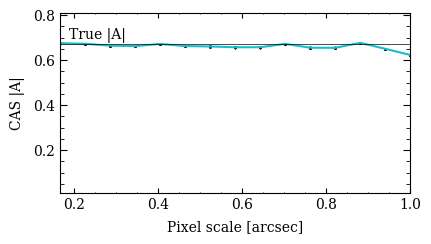

In [124]:
plt.figure(figsize=(3.5,1.8))
ax = plt.axes()

# Data points
ax.scatter(px_df.pxscale, px_df.a_cas, color='k', s=10)

# Median
qs = px_df.groupby(by='pxscale').quantile(q=[0.16, 0.5, 0.84])
ax.plot(pxscales, qs.xs(0.5, level=1).a_cas, color='C9')
ax.fill_between(pxscales, qs.xs(0.16, level=1).a_cas, qs.xs(0.84, level=1).a_cas, color='C9', alpha=0.2)
ax.axhline(a_cas_real, color='k', lw=0.5)

# Annotations
ax.annotate('True |A|', xy=(0.19, a_cas_real+0.005), size=10, ha='left', va='bottom')

# Limits
# ax.set_xlim(19.51, 28.49)
ax.set_ylim(0.01, 0.81)
ax.set_ylabel('CAS |A|')
ax.set_xlabel(r'Pixel scale [arcsec]')

plt.savefig('figures/paper/cas_a_px.pdf', bbox_inches='tight')

#### Corrected CAS

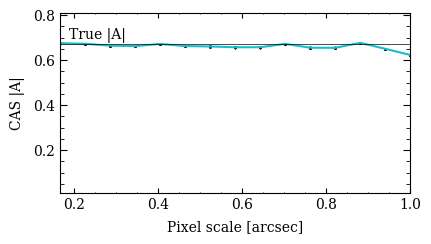

In [123]:
plt.figure(figsize=(3.5,1.8))
ax = plt.axes()

# Data points
ax.scatter(px_df.pxscale, px_df.a_cas_cor, color='k', s=10)

# Median
qs = px_df.groupby(by='pxscale').quantile(q=[0.16, 0.5, 0.84])
ax.plot(pxscales, qs.xs(0.5, level=1).a_cas_cor, color='C9')
ax.fill_between(pxscales, qs.xs(0.16, level=1).a_cas_cor, qs.xs(0.84, level=1).a_cas_cor, color='C9', alpha=0.2)
ax.axhline(a_cas_real, color='k', lw=0.5)

# Annotations
ax.annotate('True |A|', xy=(0.19, a_cas_real+0.005), size=10, ha='left', va='bottom')

# Limits
# ax.set_xlim(19.51, 28.49)
ax.set_ylim(0.01, 0.81)
ax.set_ylabel('CAS |A|')
ax.set_xlabel(r'Pixel scale [arcsec]')

plt.savefig('figures/paper/cas_a_corr_px.pdf', bbox_inches='tight')

#### Squared

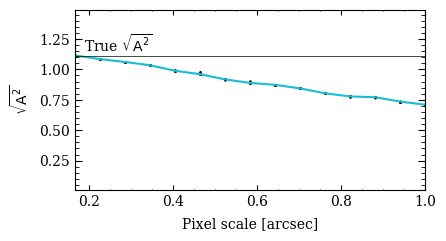

In [122]:
px_df['a_sq_root'] = np.sqrt(px_df.a_sq/10)

plt.figure(figsize=(3.5,1.8))
ax = plt.axes()

# Data points
ax.scatter(px_df.pxscale, px_df.a_sq_root, color='k', s=10)

# Median
qs = px_df.groupby(by='pxscale').quantile(q=[0.16, 0.5, 0.84])
ax.plot(pxscales, qs.xs(0.5, level=1).a_sq_root, color='C9')
ax.fill_between(pxscales, qs.xs(0.16, level=1).a_sq_root, qs.xs(0.84, level=1).a_sq_root, color='C9', alpha=0.2)
ax.axhline(np.sqrt(a_sq_real/10), color='k', lw=0.5)

# Annotations
ax.annotate(r'True $\sqrt{A^2}$', xy=(0.19, np.sqrt(a_sq_real/10)+0.005), size=10, ha='left', va='bottom')

# Limits
# ax.set_xlim(19.51, 28.49)
ax.set_ylim(0.01, 1.49)
ax.set_ylabel(r'$\sqrt{A^2}$')
ax.set_xlabel(r'Pixel scale [arcsec]')

plt.savefig('figures/paper/a_sq_px.pdf', bbox_inches='tight')

## Save data

In [127]:
psf_df.to_csv('data/psf_series.csv', index=False)
px_df.to_csv('data/px_series.csv', index=False)
sky_mags_df.to_csv('data/sky_series.csv', index=False)

## Aperture size

In [134]:
def get_asymmetry_measurements(img_obs, pxscale, ap_frac=1.5):
    
    #### Calculate noisy asymmetries
    a_cas, _ = get_asymmetry(img_obs, ap_frac*r_pet/pxscale, a_type='cas', sky_type='annulus', bg_corr='residual', sky_annulus=[1.5, 3])
    a_cas_corr, _ = get_asymmetry(img_obs, ap_frac*r_pet/pxscale, a_type='cas_corr', sky_type='annulus', bg_corr='residual', sky_annulus=[1.5, 3])

    ##### Store output
    output = {
        'a_cas' : a_cas, 'a_cas_cor' : a_cas_corr
    }
    
    return output
    

In [152]:
aps = np.linspace(1,2.5,10)
n_sims = 1
mag = 23

dicts = []

img_noisy, sky_flux = sky_noise(img_perfect, sky_mag=mag, pixel_scale=perfect_pxscale, rms_noise=True)

for apsize in tqdm(aps):
    for n in range(n_sims):
        out = get_asymmetry_measurements(img_noisy, perfect_pxscale, apsize)
        
        # Get SNR/pixel
        noise_arr = np.sqrt( (img_perfect) + sky_flux**2 )
        ap = aperture.CircularAperture(xc, apsize*r_pet/perfect_pxscale)
        snr = ap.do_photometry(img_noisy)[0][0]/ap.do_photometry(noise_arr)[0][0] 
        
        out['apsize'] = apsize
        out['n'] = n
        out['snr'] = snr
        dicts.append(out)
        
ap_size_df = pd.DataFrame(dicts)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'Aperture size [R$_p$]')

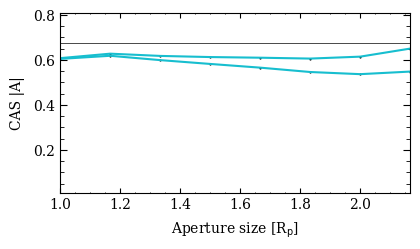

In [153]:
plt.figure(figsize=(3.5,1.8))
ax = plt.axes()

# Data points
ax.scatter(ap_size_df.apsize, ap_size_df.a_cas, color='k', s=10)
ax.scatter(ap_size_df.apsize, ap_size_df.a_cas_cor, color='k', s=10)

# Median
qs = ap_size_df.groupby(by='apsize').quantile(q=[0.16, 0.5, 0.84])
ax.plot(aps, qs.xs(0.5, level=1).a_cas, color='C9')
ax.fill_between(aps, qs.xs(0.16, level=1).a_cas, qs.xs(0.84, level=1).a_cas, color='C9', alpha=0.2)
ax.plot(aps, qs.xs(0.5, level=1).a_cas_cor, color='C9')
ax.fill_between(aps, qs.xs(0.16, level=1).a_cas_cor, qs.xs(0.84, level=1).a_cas_cor, color='C9', alpha=0.2)

ax.axhline(a_cas_real, color='k', lw=0.5)

# Annotations
ax.annotate('True |A|', xy=(0.19, a_cas_real+0.005), size=10, ha='left', va='bottom')

# Limits
# ax.set_xlim(19.51, 28.49)
ax.set_ylim(0.01, 0.81)
ax.set_ylabel('CAS |A|')
ax.set_xlabel(r'Aperture size [R$_p$]')

# plt.savefig('figures/paper/cas_a_px.pdf', bbox_inches='tight')